# ChemometricsPLS
## Scikit-Learn based objects for Chemometrics

Code and data imports
Dataset used in example is TRACE Lipofit data

In [5]:
import pandas as pds
from ChemometricsPLS import ChemometricsPLS as chempls
from ChemometricsScaler import ChemometricsScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Read lipofit data, perfect example for CV testing since it has classes and nested data
matrix = pds.read_csv('ExampleFile(TRACElipofitmat).csv')
# the X matrix
xmat = matrix.iloc[:, 9::]
%matplotlib inline

ymat = matrix.iloc[:, 8].values

One of the arguments for the ChemometricsPLS object constructor is the choice of scaling.  
When a scikit-Learn-like preprocessing TransformerMixin/Scaler is passed to the ChemometricsPCA object, it 
will be used consistently throughout all the object.  

The ChemometricsScaler object is a modification of the default scikit-learn StandardScaler.  
It contains a parameter, scale_power, which is the power to which the standard deviation vector will be raised for the scaling.  
Typical Values:  
0 - Mean Centering only  
1/2 - Pareto Scaling  
1 - UV/Unit Variance, StandardScaler  

In [6]:
scalerobj = ChemometricsScaler(scale_power=1)

In [11]:
ChmxPCA = chempls(ncomps=3, xscaler=scalerobj, yscaler=scalerobj, metadata=None)

The constructor for the ChemometricsPLS object has the arguments ncomps (number of principal components), pls_algorithm (which base scikit-learn algorithm to use), scaler (the scikit-learn scaler object as described) and metadata (a pandas dataframe, whose point is to contain metadata to use in plots and Stratified-Cross-Validation).
Keyword arguments can be passed, usefull to provide extra parameters for different types of PCA algorithms.

The pca_algorithm takes all scikit-learn objects that inherit from the abstract \_BasePCA class.  
At the momment these are:  
PCA - the default SVD PCA.  
TruncatedSVD - Usefull for sparse matrices
Incremental PCA - For batch fitting of large datasets  

Other types of PCA and factor models, including KernelPCA, are in theory possible, 
but these have to be discussed on a case per case basis, as variance explained, 
model performance or even loadings are sometimes not defined.

The behaviour of the model is identical to standard scikit-learn models

In [4]:
ChmxPCA.fit(xmat.values)
scores = ChmxPCA.transform(xmat.values)

After the model is fitted, internal attributes containing the Variance explained, scores and loadings are generated.
The scaling is consistant

In [1]:
print(ChmxPCA.modelParameters)
print(ChmxPCA.scores.shape)
print(ChmxPCA.loadings.shape)
plt.plot(ChmxPCA.loadings.T)
plt.show()

NameError: name 'ChmxPCA' is not defined

Appropriate setters are inplace to ensure the appropriate action (re-fit, reset model stats) is taken when internal parameters are changed. Most methods take keyword arguments apart from the arguments here described. This ensures model specific arguments can still be used easily (for ex:, solver initial conditions and tolerances). 

In [2]:
ChmxPCA.scaler = ChemometricsScaler(0)
print('After changing the scaling, the loadings are equal to: ' + str(ChmxPCA.loadings))
ChmxPCA.fit(xmat.values)
#print('Loadings for mean centered data:')

plt.plot(ChmxPCA.loadings.T)
plt.show()
# Return to normal
ChmxPCA.scaler = ChemometricsScaler(1)

NameError: name 'ChemometricsScaler' is not defined

To perform model parameter optimization and cross-validate the ChemometricsPCA object, we can employ the default scikit-learn tools (including Pipeline).  
A specific cross_validation method is also provided, for automated calculation of cross-validated performance measures.  

The arguments for this method include:  
x - The data to use incross_validation  
method - An instance of scikit-learn BaseCrossValidator. The default is KFold(7, True), 7-fold with shuffling of rows is used by default.  
outputdist: If true, the whole distribution of model performance metrics and loadings obtained during cross-validation is returned, in addition to its default summary statistics (mean and standard deviations).   
bro_press: How to calculate the PRESS and RSS statistics. If set to false, row-wise cross-validation is used. If true, the Eigenvector_PRESS algorithm (as described in Bro et al 2005) is used to calculate model statistics (VarianceExplained in test set, PRESS and Q2).

In [7]:
ChmxPCA.cross_validation(xmat.values, outputdist=True, bro_press=True)

Scaling is recalculated inside each CV round, and the sign indeterminacy of the PCA solution is addressed by selecting the sign of the loadings that minimizes the sum of absolute differences from the corresponding loadings calculated with on the whole dataset.  
After cross-validation, a new attribute, cvParameters is created in the object.

dict_keys(['CV_VarExp_Test', 'Mean_VarExp_Test', 'CV_Loadings', 'Stdev_VarExpRatio_Training', 'Mean_Loadings', 'Mean_VarExpRatio_Training', 'CV_VarExpRatio_Training', 'Stdev_Loadings', 'Q2', 'Stdev_VarExp_Test'])


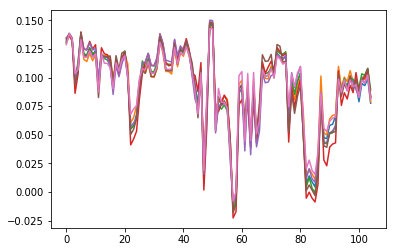

Loadings calculated during the CV for component number 1, after sign indeterminacy re-flip


In [8]:
print(ChmxPCA.cvParameters.keys())
plt.plot(ChmxPCA.cvParameters['CV_Loadings'][0].T)
plt.show()
print('Loadings calculated during the CV for component number 1, after sign indeterminacy re-flip')

Comparison of model performance for multiple components (such as in selection of number of components) can be easily with multiple calls to the cross_validation function.  
An example follows, displaying a comparison between the statistics calculated with row-wise CV versus Eigenvector_PRESS CV. 

In [9]:
ncomps = 3

qsquareds = []
r2test = []
r2test_var = []

for curr_ncomp in range(1, ncomps+1):
    pca = chempca(ncomps=curr_ncomp)
    pca.cross_validation(x=xmat.values, bro_press=False)
    qsquareds.append(pca.cvParameters['Q2'])
    r2test.append(pca.cvParameters['Mean_VarExp_Test'])
    r2test_var.append(pca.cvParameters['Stdev_VarExp_Test'])
qsquareds_bro= []
r2test_bro = []
r2test_brovar = []
for curr_ncomp in range(1, ncomps+1):
    pca = chempca(ncomps=curr_ncomp)
    pca.cross_validation(x=xmat.values, bro_press=True)
    qsquareds_bro.append(pca.cvParameters['Q2'])
    r2test_bro.append(pca.cvParameters['Mean_VarExp_Test'])
    r2test_brovar.append(pca.cvParameters['Stdev_VarExp_Test'])

The model performance metrics available are:
VarExpRatio of the global model (obtained from .modelParameters and not cvParameters): The VarianceExplained proportion obtained when fitting the whole dataset.

VarExp_Train: The VarianceExplained values obtained for all Principal components when fitting the data in the training set. Not a reliable way to assess reliability of prediction, but might be interesting to see the variability in the model fitting and stability of components. Can be interpreted in conjunction with the CV loadings. 

Q2: A single summary statistics. One of the default metrics for model assessment in Chemometrics. BAsed on the PRESS/RSS calculated from all the test sets. Single value for the whole model. 

VarExp_Test: The variance explained by the whole model in each CV round, but calculated on the test set. One value for each round of cross_validation. Although its mean value should be similar to Q2 in the end, the distribution can be used to assess the variability of the predictive power estimate, something the Q2 does not convey.

All these are provided as mean and standard deviation (summary) or in bulk (whole distributions)

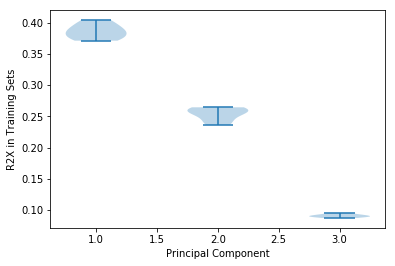

The cross-validated variance explained calculated in the training set


In [10]:
ChmxPCA.cross_validation(xmat.values, outputdist=True, bro_press=True)
fig, ax = plt.subplots()
ax.violinplot(np.array(ChmxPCA.cvParameters['CV_VarExpRatio_Training']))
plt.xlabel('Principal Component')
plt.ylabel('R2X in Training Sets')
plt.show()
print('The cross-validated variance explained calculated in the training set')

In [13]:
%matplotlib qt
location = np.arange(ncomps)  # the x locations for the groups
width = 0.4      # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(location, r2test, width/4, color='b', yerr=[2*x for x in r2test_var])
rects2 = ax.bar(location + 0.25*width, r2test_bro, width/4, color='r', yerr=[2*x for x in r2test_brovar])
rects3 = ax.bar(location + 0.5*width,  qsquareds, width/4, color='g')
rects4 = ax.bar(location + 0.75*width,  qsquareds_bro, width/4, color='k')
ax.set_ylabel('Variance Explained')
ax.set_xlabel('PCA component')
ax.set_title('PerformanceMetrics')
ax.set_xticks(location+ 0.7*width/2)
ax.set_xticklabels((1, 2, 3 ))

ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]), ('R2X_TestSet-Row-wise CV', 'R2X_TestSet-EigenvectorPRESS CV', 'Q2X_Row-wiseCV', 'Q2X_EigenvectorPRESS CV'))
plt.show()

As an extra, 2 permutation tests have been implemented for PCA:  
permutationtest_components:  Permute multiple elements in various columns of the matrix at once destroy multivariate structure in X and generate a null distribution for the Variance Explained per components - To assess significance of components/model.  
permutationtest_loadings: Permute each variable X times. Maintaisn general multivariate structure in X, but breaks the association of each variable with the remaining component/correlation structure in X. Slower, but generates a null distribution for the loading magnitude for each variable in each component. 

In [12]:
perm_null_comps = ChmxPCA.permutationtest_components(xmat.values, 1000)

AttributeError: 'ChemometricsPCA' object has no attribute 'ModelParameters'

In [ ]:
permu_null_loadings = ChmxPCA.permutationtest_loadings(xmat.values, 1000)

In [ ]:
%matplotlib inline
plt.hist(permu_null_loadings[1][:, 0], 20)
plt.show()